# Example 5.4: Illustration of Early Stopping and Weight Decay on CIFAR10 dataset

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [2]:
batch_size = 256
max_epochs = 100

patience = 10
dropouts = 0.1
weight_decay = 0.001
hidden_size = 400

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=500):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
class NeuralNetwork_dropout(nn.Module):
    def __init__(self, hidden_size = 100, drop_out=0.5):
        super(NeuralNetwork_dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(hidden_size, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    test_correct /= size
    
    return test_loss, test_correct

In [7]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [8]:
model = NeuralNetwork(hidden_size=hidden_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 34.26%, Train_loss: 0.008270, Test_accuracy: 37.84%, Test_loss: 0.008306
Epoch 2: Train_accuracy: 39.72%, Train_loss: 0.008071, Test_accuracy: 41.49%, Test_loss: 0.008164
Epoch 3: Train_accuracy: 41.96%, Train_loss: 0.007984, Test_accuracy: 43.26%, Test_loss: 0.008102
Epoch 4: Train_accuracy: 44.27%, Train_loss: 0.007896, Test_accuracy: 42.89%, Test_loss: 0.008113
Epoch 5: Train_accuracy: 44.07%, Train_loss: 0.007907, Test_accuracy: 43.44%, Test_loss: 0.008095
Epoch 6: Train_accuracy: 45.07%, Train_loss: 0.007869, Test_accuracy: 43.28%, Test_loss: 0.008110
Epoch 7: Train_accuracy: 45.93%, Train_loss: 0.007836, Test_accuracy: 45.16%, Test_loss: 0.008028
Epoch 8: Train_accuracy: 46.50%, Train_loss: 0.007816, Test_accuracy: 45.33%, Test_loss: 0.008030
Epoch 9: Train_accuracy: 45.70%, Train_loss: 0.007846, Test_accuracy: 44.60%, Test_loss: 0.008060
Epoch 10: Train_accuracy: 46.33%, Train_loss: 0.007823, Test_accuracy: 44.22%, Test_loss: 0.008086
Epoch 11: Train_acc

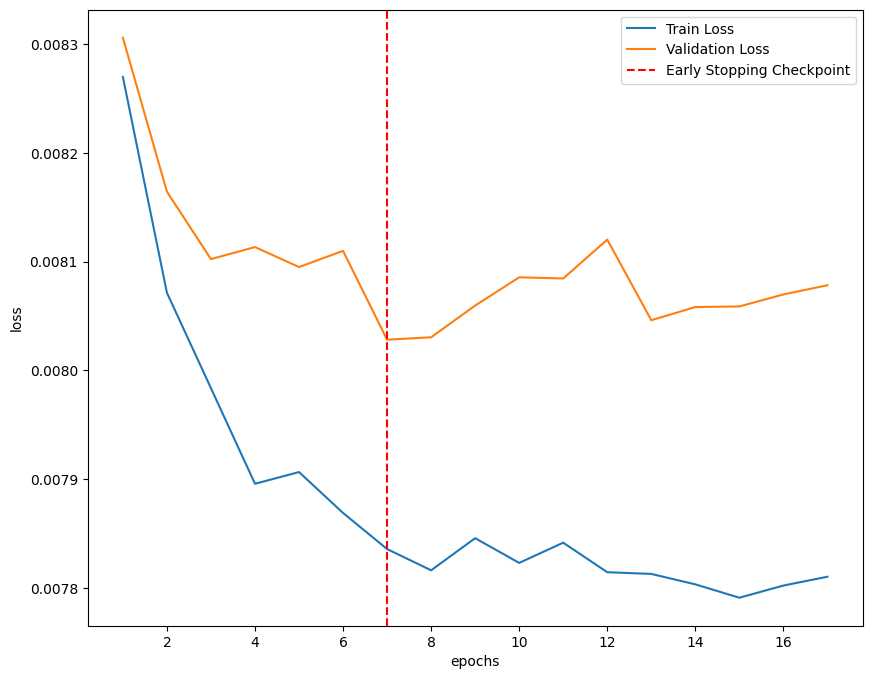

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Train Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model = NeuralNetwork(hidden_size=hidden_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr1_loss, tr1_correct = [], []
te1_loss, te1_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr1_loss.append(train_loss), tr1_correct.append(train_correct)
    te1_loss.append(test_loss), te1_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 33.29%, Train_loss: 0.008313, Test_accuracy: 36.44%, Test_loss: 0.008357
Epoch 2: Train_accuracy: 37.60%, Train_loss: 0.008152, Test_accuracy: 38.76%, Test_loss: 0.008281
Epoch 3: Train_accuracy: 40.23%, Train_loss: 0.008053, Test_accuracy: 40.58%, Test_loss: 0.008219
Epoch 4: Train_accuracy: 41.17%, Train_loss: 0.008016, Test_accuracy: 41.55%, Test_loss: 0.008177
Epoch 5: Train_accuracy: 42.38%, Train_loss: 0.007973, Test_accuracy: 42.44%, Test_loss: 0.008132
Epoch 6: Train_accuracy: 43.88%, Train_loss: 0.007911, Test_accuracy: 42.07%, Test_loss: 0.008147
Epoch 7: Train_accuracy: 44.67%, Train_loss: 0.007889, Test_accuracy: 44.18%, Test_loss: 0.008085
Epoch 8: Train_accuracy: 45.05%, Train_loss: 0.007869, Test_accuracy: 44.14%, Test_loss: 0.008074
Epoch 9: Train_accuracy: 45.95%, Train_loss: 0.007838, Test_accuracy: 44.50%, Test_loss: 0.008051
Epoch 10: Train_accuracy: 46.69%, Train_loss: 0.007808, Test_accuracy: 45.03%, Test_loss: 0.008034
Epoch 11: Train_acc

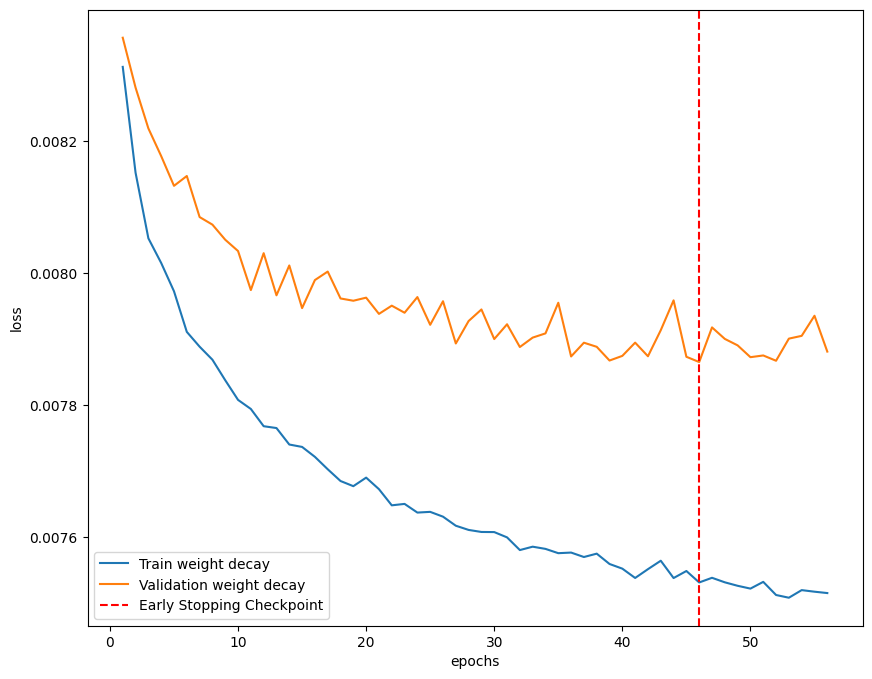

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, label='Train weight decay')
plt.plot(range(1,len(te1_loss)+1),te1_loss,label='Validation weight decay')

# find position of lowest validation loss
minposs = te1_loss.index(min(te1_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

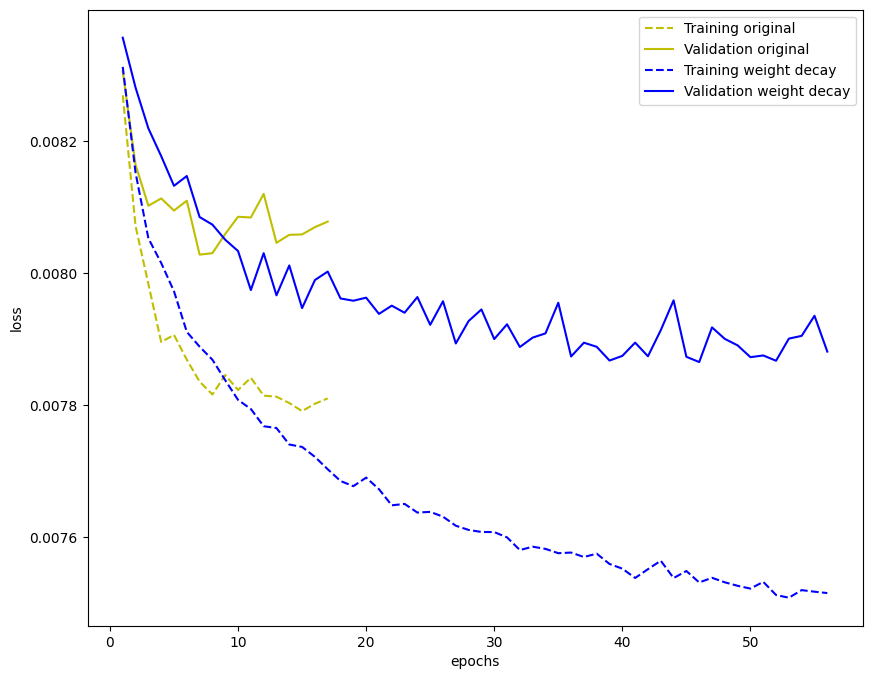

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, linestyle = '--', color = 'y', label='Training original')
plt.plot(range(1,len(te_loss)+1),te_loss, color = 'y', label='Validation original')
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, linestyle = '--', color = 'b', label='Training weight decay')
plt.plot(range(1,len(te1_loss)+1),te1_loss, color = 'b', label='Validation weight decay')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()